$\cos(\phi)$ Dipole Magnet

In [1]:
import fenics as fn
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import mu_0

# Generate Mesh

## Produce Mesh

In [48]:
# This is to produce the mesh from within Jupyter
!gmsh -2 geometry/magnet.geo -order 1 -format msh2
!dolfin-convert geometry/magnet.msh magnet/magnet.xml

Info    : Running 'gmsh -2 geometry/magnet.geo -order 1 -format msh2' [Gmsh 4.1.3, 1 node, max. 1 thread]
Info    : Started on Mon Aug 17 23:14:17 2020
Info    : Reading 'geometry/magnet.geo'...
Info    : Done reading 'geometry/magnet.geo'
Info    : Meshing 1D...
Info    : Meshing curve 2 (Circle)
Info    : Meshing curve 3 (Circle)
Info    : Meshing curve 4 (Circle)
Info    : Meshing curve 5 (Circle)
Info    : Meshing curve 6 (Circle)
Info    : Meshing curve 7 (Circle)
Info    : Meshing curve 8 (Circle)
Info    : Meshing curve 9 (Circle)
Info    : Meshing curve 10 (Line)
Info    : Meshing curve 11 (Line)
Info    : Meshing curve 12 (Line)
Info    : Meshing curve 13 (Line)
Info    : Meshing curve 14 (Line)
Info    : Meshing curve 15 (Line)
Info    : Meshing curve 16 (Line)
Info    : Meshing curve 17 (Line)
Info    : Meshing curve 18 (Circle)
Info    : Meshing curve 19 (Line)
Info    : Meshing curve 20 (Line)
Info    : Meshing curve 21 (Line)
Info    : Meshing curve 22 (Circle)
Info    : 

In [49]:
%matplotlib inline

## Import Mesh and Boundaries

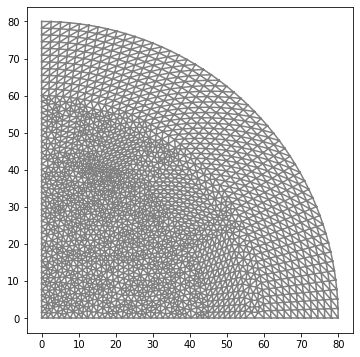

In [50]:
mesh = fn.Mesh('magnet/magnet.xml')
subdomains = fn.MeshFunction("size_t", mesh, 'magnet/magnet_physical_region.xml')
boundaries = fn.MeshFunction('size_t', mesh, 'magnet/magnet_facet_region.xml')

plt.figure(figsize=(10, 6))
fn.plot(mesh)
plt.show()

## Produce measures

In [51]:
dx = fn.Measure('dx', domain=mesh, subdomain_data=subdomains)
ds = fn.Measure('ds', domain=mesh, subdomain_data=boundaries)
V0 = fn.FunctionSpace(mesh, 'DG', 0)
V = fn.FunctionSpace(mesh, 'P', 2)

## Boundary Conditions

In [52]:
outer_boundary = fn.DirichletBC(V, fn.Constant(0), boundaries, 5)
dc = fn.DirichletBC(V, fn.Constant(0), boundaries, 4)
bcs = [outer_boundary, dc]

## Source Current Density

In [53]:
# Magnet made (very roughly) to resemble the dipole magnet in
# The Superconducting Super Proton Synchrotron report
# http://cds.cern.ch/record/2681200?ln=en
# Credit to Luke Dyks
num_wires = 28
area = fn.assemble(1*dx(2))
I = 12119

class j(fn.UserExpression):
    def __init__(self, markers, **kwargs):
        self.markers = markers
        super().__init__(**kwargs)
        
    def eval_cell(self, values, x, cell):
        if self.markers[cell.index] == 2:
            values[0] = I * num_wires / area
        else:
            values[0] = 0
    
        return 0

current_density = j(subdomains, degree=1)

In [54]:
I * num_wires/area

659.1713173066814

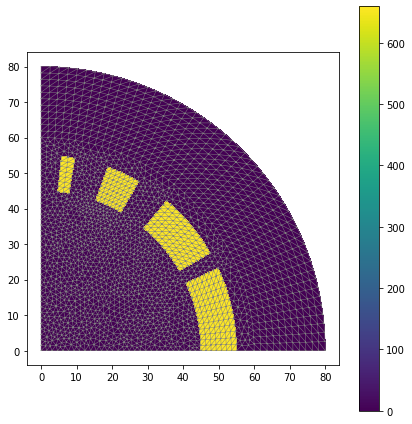

In [55]:
plt.figure(figsize=(6,6))
fn.plot(mesh, linewidth=0.5)
p = fn.plot(fn.project(current_density, V0))
plt.colorbar(p)
plt.tight_layout()
plt.show()

## Surrounding Yoke

In [9]:
class Permeability(fn.UserExpression):
    def __init__(self, markers, **kwargs):
        super().__init__(kwargs)
        self.markers = markers
        
    def eval_cell(self, values, x, cell):
        if self.markers[cell.index] == 6:
            values[0] = 4e3 * mu_0
        else:
            values[0] = mu_0 # vacuum

mu = Permeability(subdomains, degree=1)

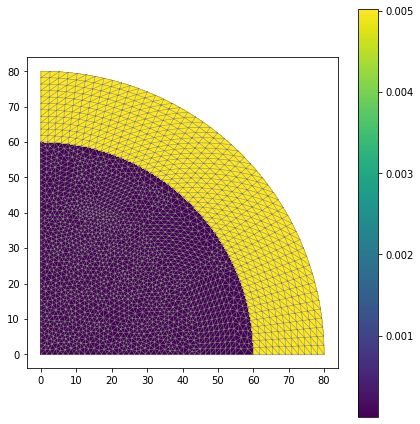

In [10]:
plt.figure(figsize=(6,6))
fn.plot(mesh, linewidth=0.5)
p = fn.plot(fn.project(mu, V0))
plt.colorbar(p)
plt.tight_layout()
plt.show()

# Solve

In [56]:
# Define variational problem
A_z = fn.TrialFunction(V)
v = fn.TestFunction(V)
a = 1 / mu*fn.dot(fn.grad(A_z), fn.grad(v))*dx
L = current_density*v*dx

# Solve variational problem
A_z = fn.Function(V)
fn.solve(a == L, A_z, bcs)

# Compute magnetic field (B = curl A)
W = fn.VectorFunctionSpace(mesh, 'P', 2)
#B = fn.project(fn.as_vector((A_z.dx(1), -A_z.dx(0))), W)


Calling FFC just-in-time (JIT) compiler, this may take some time.


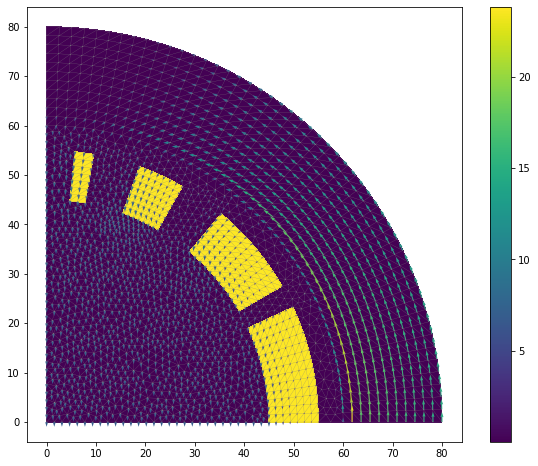

In [81]:
BB = fn.as_vector((A_z.dx(1), -A_z.dx(0)))

%matplotlib inline
plt.close('all')
plt.figure(figsize=(10, 8))
fn.plot(fn.project(current_density, V0))
fn.plot(mesh, linewidth=0.2)
p = fn.plot(BB*1e3)
plt.colorbar(p)
plt.show()

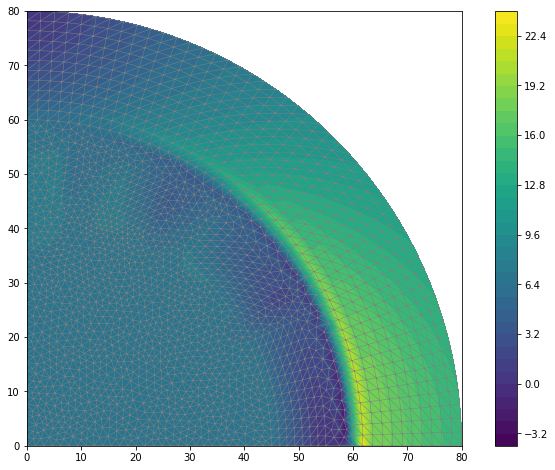

In [79]:
# calculate derivatives
Bx = A_z.dx(1)
By = -A_z.dx(0)

B_abs = 1e3*np.power( Bx**2 + By**2, 0.5 ) # compute length of vector
plt.figure(figsize=(12, 8))
#fn.plot(fn.project(current_density, V0))
fn.plot(mesh, linewidth=0.5)
p = fn.plot(B_abs, alpha=1)
#fn.plot(BB*1e3)
plt.colorbar(p)
plt.show()

In [80]:
fn.project(BB, W)(5,50) * 1e3

array([-0.42875359, -7.96215929])

In [26]:
vtkfile = fn.File('output/b_field.pvd')
vtkfile << fn.project(BB, W)

## Discontunity Issue

<Figure size 864x576 with 0 Axes>

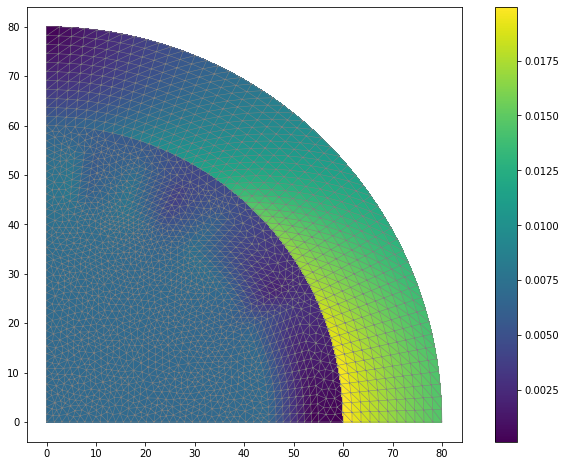

In [33]:
# POSTPROCESSING
# https://scicomp.stackexchange.com/questions/32844/electromagnetism-fem-fenics-interpolation-leakage-effect

# calculate derivatives
Bx = A_z.dx(1)
By = -A_z.dx(0)

B_abs = np.power( Bx**2 + By**2, 0.5 ) # compute length of vector

# define new function space as Discontinuous Galerkin
abs_B = fn.FunctionSpace(mesh, 'DG', 0)
f = B_abs # obtained solution is "source" for solving another PDE

# make new weak formulation
w_h = fn.TrialFunction(abs_B)
v = fn.TestFunction(abs_B)

a = w_h*v*dx
L = f*v*dx

w_h = fn.Function(abs_B)
fn.solve(a == L, w_h)

# plot the solution
plt.figure(figsize=(12, 8))

plt.show()

plt.figure(figsize=(12, 8))
#fn.plot(fn.project(current_density, V0))
fn.plot(mesh, linewidth=0.5)
p = fn.plot(w_h, alpha=1)
plt.colorbar(p)
plt.show()